In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt

In [40]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
train_data

11.8%

100.1%

Extracting ./Data/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting ./Data/MNIST/raw/train-labels-idx1-ubyte.gz


55.1%

180.4%

Extracting ./Data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./Data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [41]:
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [42]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [43]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


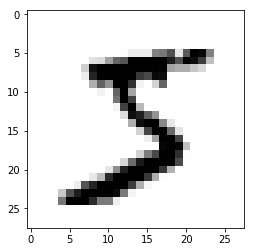

In [44]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

In [45]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


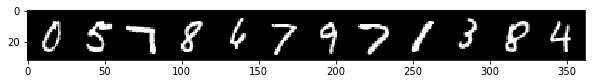

In [46]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [47]:
class MultilayerPerceptron(nn.Module):
    def  __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
        

In [48]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
images.view(100, -1).shape

torch.Size([100, 784])

In [52]:
import time
start_time = time.time()

# TRAINING
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

epoch 0 batch 200 loss: 0.28055405616760254 accuracy: 83.04
epoch 0 batch 400 loss: 0.20303486287593842 accuracy: 87.325
epoch 0 batch 600 loss: 0.20227622985839844 accuracy: 89.32333333333334
epoch 1 batch 200 loss: 0.1445707380771637 accuracy: 94.56
epoch 1 batch 400 loss: 0.10489676147699356 accuracy: 95.11
epoch 1 batch 600 loss: 0.12034723162651062 accuracy: 95.34666666666666
epoch 2 batch 200 loss: 0.11627216637134552 accuracy: 96.53
epoch 2 batch 400 loss: 0.08906286954879761 accuracy: 96.615
epoch 2 batch 600 loss: 0.10235453397035599 accuracy: 96.74
epoch 3 batch 200 loss: 0.05358913540840149 accuracy: 97.475
epoch 3 batch 400 loss: 0.055334705859422684 accuracy: 97.485
epoch 3 batch 600 loss: 0.05723266303539276 accuracy: 97.51
epoch 4 batch 200 loss: 0.12977652251720428 accuracy: 97.96
epoch 4 batch 400 loss: 0.09529872983694077 accuracy: 98.0125
epoch 4 batch 600 loss: 0.1226351335644722 accuracy: 98.055
epoch 5 batch 200 loss: 0.042167216539382935 accuracy: 98.33
epoch 5 b

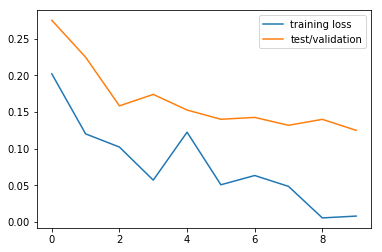

In [53]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test/validation')
plt.legend()

In [54]:
train_acc = [t/600 for t in train_correct]
test_acc = [t/100 for t in test_correct]

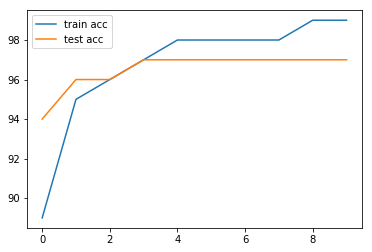

In [55]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend();

In [56]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [57]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9756/10000 =  97.560%


In [58]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 970    0    0    0    1    2    4    1    3    3]
 [   0 1121    2    0    0    0    4    3    0    2]
 [   1    5 1001    3    1    0    2    7    3    0]
 [   3    2    9  998    1   25    1    3    6   16]
 [   0    0    3    0  965    1    5    1    3   12]
 [   0    0    0    0    0  849    1    0    2    4]
 [   1    2    1    0    4    6  939    0    1    0]
 [   0    1    6    6    3    1    0 1007    3   11]
 [   3    4   10    3    2    8    2    4  951    6]
 [   2    0    0    0    5    0    0    2    2  955]]
